# Normal Model and Synthetic Data

In [1]:
%load_ext autoreload
%autoreload 2

import warnings

import matplotlib.pyplot as plt
import pandas as pd
from utils import generate_data, match

from famo.core import CORE
from famo.plotting import plot_variance_explained

warnings.simplefilter(action="ignore", category=FutureWarning)

## Data Generation

In [2]:
data = generate_data(
    n_samples={"group_1": 1000, "group_2": 1200},
    n_features={"view_1": 200, "view_2": 250},
    n_factors=3,
    likelihoods={"view_1": "Normal", "view_2": "Normal"},
)

## Model Fitting

In [3]:
# Run model with MuData object
model = CORE(device="cuda")
model.fit(
    n_factors=3,
    data=data,
    factor_prior="Horseshoe",
    weight_prior="SnS",
    lr=0.005,
    early_stopper_patience=500,
    print_every=20,
    center_groups=True,
    scale_views=False,
    scale_groups=True,
    max_epochs=1000,
    init_factors="random",
    init_scale=0.1,
    save=True,
)

Setting up device...
- No device id given. Using default device: 0
- Running all computations on `cuda:0`
- No likelihoods provided. Inferring likelihoods from data.
  - view_1: Normal
  - view_2: Normal
- Centering group_1/view_1...
- Centering group_1/view_2...
- Centering group_2/view_1...
- Centering group_2/view_2...


/data/walter/famo/src/famo/utils_data.py:278: RuntimeWarning: Mean of empty slice
  means[k_groups][k_views] = np.nanmean(v_views.X, axis=0)


alt.Chart(...)

alt.Chart(...)

Initializing factors using `random` method...
Decaying learning rate over 1000 iterations.
Setting training seed to `2409171417`.
Cleaning parameter store.
Epoch:       0 | Time:       1.26s | Loss:     535.40
Epoch:      20 | Time:       2.08s | Loss:     530.94
Epoch:      40 | Time:       2.89s | Loss:     528.61
Epoch:      60 | Time:       3.71s | Loss:     524.87
Epoch:      80 | Time:       4.65s | Loss:     514.63
Epoch:     100 | Time:       5.48s | Loss:     507.04
Epoch:     120 | Time:       6.29s | Loss:     486.98
Epoch:     140 | Time:       7.10s | Loss:     469.35
Epoch:     160 | Time:       7.91s | Loss:     454.76
Epoch:     180 | Time:       8.73s | Loss:     436.60
Epoch:     200 | Time:       9.54s | Loss:     409.88
Epoch:     220 | Time:      10.35s | Loss:     395.39
Epoch:     240 | Time:      11.15s | Loss:     386.58
Epoch:     260 | Time:      11.91s | Loss:     350.99
Epoch:     280 | Time:      12.71s | Loss:     344.02
Epoch:     300 | Time:      13.52s

AttributeError: 'Variational' object has no attribute 'expectation'

## Variance Explained Analysis

In [ ]:
plot_variance_explained(model)

alt.HConcatChart(...)

## Assignment of Inferred to True Factors

In [ ]:
group = "group_1"
view = "view_1"

w = model.get_weights("pandas")[view]
z = model.get_factors("pandas")[group]

w_gt = pd.DataFrame(data[group][view].varm["w"].T, columns=data[group][view].var_names)
z_gt = pd.DataFrame(data[group][view].obsm["z"], index=data[group][view].obs_names)

z_common_indices = z.index.intersection(z_gt.index)
z = z.loc[z_common_indices].sort_index(axis=0)
z_gt = z_gt.loc[z_common_indices].sort_index(axis=0)

w_common_cols = w.columns.intersection(w_gt.columns)
w = w.loc[:, w_common_cols]
w_gt = w_gt.loc[:, w_common_cols]

w = w.sort_index(axis=1)
w_gt = w_gt.sort_index(axis=1)

inds, signs = match(z_gt.values, z.values, dim=-1)

z = z.iloc[:, inds] * signs
w = w.iloc[inds] * signs.reshape(-1, 1)

## Correlation Plots

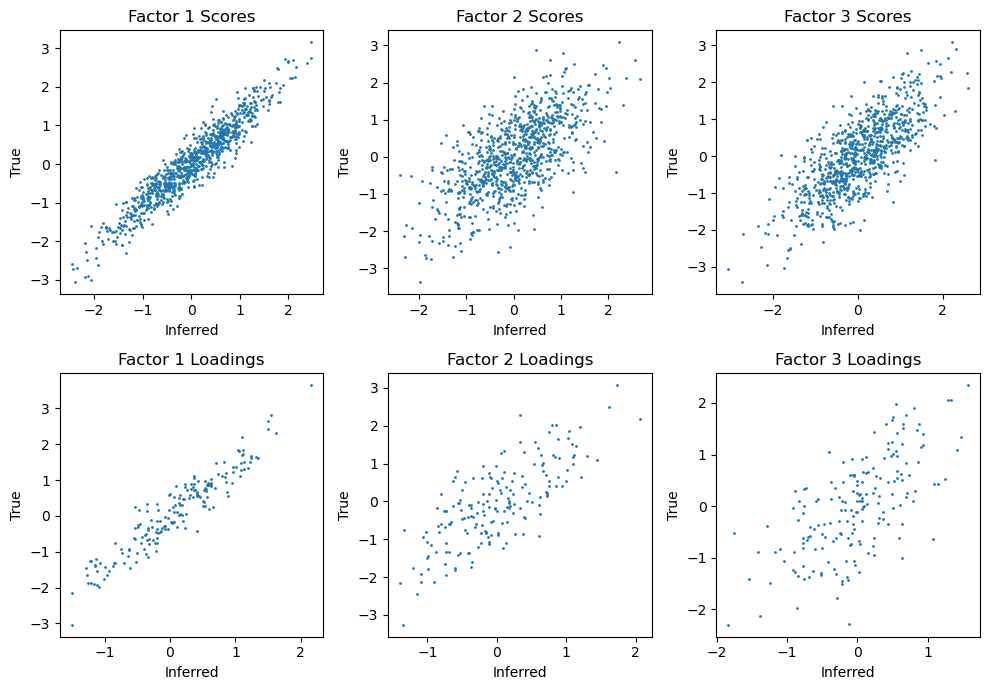

In [ ]:
fig, axs = plt.subplots(2, z.shape[1], figsize=(10, 7))
for i in range(z.shape[1]):
    axs[0, i].scatter(z.iloc[:, i], z_gt.iloc[:, i], s=1)
    axs[1, i].scatter(w.iloc[i], w_gt.iloc[i], s=1)
    axs[0, i].set_title(f"Factor {i + 1} Scores")
    axs[1, i].set_title(f"Factor {i + 1} Loadings")

for ax in axs.flatten():
    ax.set_xlabel("Inferred")
    ax.set_ylabel("True")

plt.tight_layout()